# Find wet vegetation

- Load surface reflectance
- Calculate TCG and TCW
- Find daily wet vegetation
- Summarise monthly wet vegetation

### Import

In [13]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.storage import masking

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices
from dea_datahandling import wofs_fuser
from dea_dask import create_local_dask_cluster

In [14]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33149 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:43691 Dashboard: /user/gabrielleh/proxy/33149/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


In [15]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

### Use coordinates to locate small area of interest

In [18]:
# Set the central latitude and longitude
# #Barmah
# central_lat = -35.858473
# central_lon = 145.023703


# #GKP
# central_lat = -35.847129
# central_lon = 144.386452

# Barren Grounds
# central_lat = -34.709078
# central_lon = 150.715434

# # Mac Marshes
central_lat = -30.698510
central_lon = 147.534219

# # # Yorke
# central_lat = -34.211294
# central_lon =  137.774868

# # Arafura
# central_lat = -12.562990
# central_lon =  135.035205

# # Ayr
# central_lat = -19.371645
# central_lon =  146.922991

# # Burdekin
# central_lat = -19.926378 
# central_lon =  145.626075

# # Tas
# central_lat = -42.019291
# central_lon =  146.214005

# Syd
# central_lat = -34.558100
# central_lon =  150.646049


# Set the buffer to load around the central coordinates
buffer = 0.5

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, crs='EPSG:4326', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Load surface reflectance

In [19]:
# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2016-01-01', '2016-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-30, 30),
}


data = load_ard(dc=dc,
                min_gooddata=0.1,
                products=["ga_ls8c_ard_3"], 
                group_by="solar_day", 
                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)

Scripts/dea_datahandling.py:209: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading ga_ls8c_ard_3 data
    Filtering to 34 out of 46 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 34 observations as a dask array


### Calculate TCG and TCW

In [20]:
data = calculate_indices( data, 
                          index='TCW', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)
data = calculate_indices( data, 
                          index='TCG', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


### Calculate daily and monthly wet vegetation

In [22]:
tcg_thres = 1000
tcw_thres = -350

# Daily wet vegetation
green = data.TCG > tcg_thres
wet =data.TCW > tcw_thres
not_green= wet.where(green != 1,0,0)

# Monthy maximum wet vegetation
not_green = not_green.groupby('time.month').max(dim='time')  
not_green

<xarray.DataArray 'TCW' (month: 12, y: 4091, x: 3591)>
dask.array<stack, shape=(12, 4091, 3591), dtype=int64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -3.37e+06 -3.37e+06 ... -3.492e+06 -3.492e+06
  * x            (x) float64 1.415e+06 1.415e+06 ... 1.523e+06 1.523e+06
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Plot monthly images

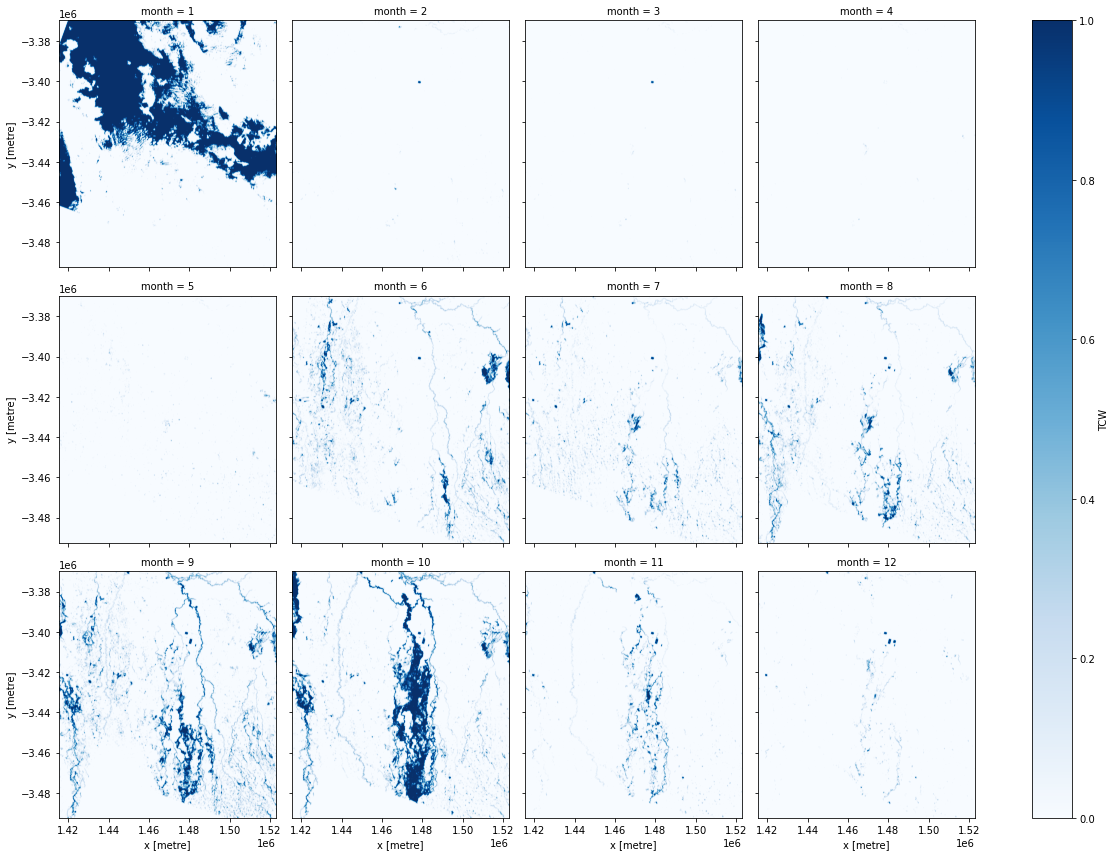

In [23]:
not_green.plot.imshow(col="month", cmap='Blues', col_wrap=4, size=4,interpolation='gaussian')
# fig = not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
# plt.savefig('foo.png')

### Annual statistics

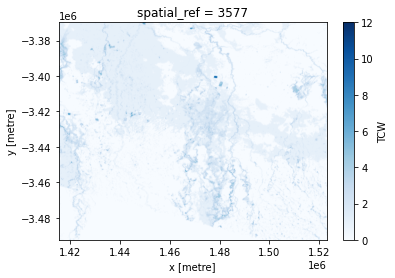

In [24]:
freq = not_green.sum(dim='month')
freq.plot.imshow(cmap='Blues',interpolation='gaussian')

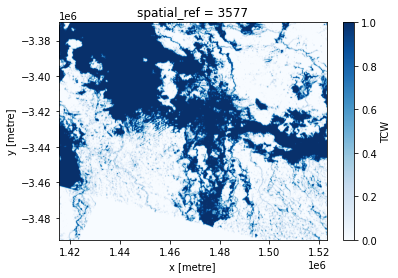

In [25]:
year_max = (freq >= 1)
year_max.plot.imshow(cmap='Blues',interpolation='gaussian')

### Write out annual statistic images

In [27]:
# cog.write_cog(freq.astype('int8'),f'freq_mac_marsh_TCG_{tcg_thres}_TCW_{tcw_thres}.tif').compute()
# cog.write_cog(year_max.astype('int8'),f'max_mac_marsh_TCG_{tcg_thres}_TCW_{tcw_thres}.tif').compute()

In [ ]:
# pwd